## Import packages

In [1]:
import xarray as xr
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
import re
import scipy.stats as sc
import scipy as scipy
import metpy as mtp
import math
from scipy import integrate
import pandas as pd
import os
import random

from matplotlib.pyplot import cm
from matplotlib.collections import LineCollection
import datetime as dt

import cartopy.crs as ccrs
from numpy.random import default_rng

import sys  
sys.path.insert(0, '../')
import ERA5_functions as era_fncts

%load_ext autoreload
%autoreload 2

### Constants

In [2]:
a=6371220 #radius of earth in m
L=2.5E6 #Latent heat in atmosphere
L_ice=3.34e5 #Latent heat of fusion
g=9.81 #Acceleration from gravity
conv_pw=1e15 #Conversion from watts to PW
cp=1007          
    

### Dims

In [3]:
lats = np.linspace(90, -90, 361)
lons = np.linspace(0, 359.5, 720)
levels = [1, 2, 3, 5, 7, 10, 20, 30, 50, 70, 100, 125, 150, 175, 200, 225, 250, 300, 350,
            400, 450, 500, 550, 600, 650, 700, 750, 775, 800, 825, 850, 875, 900, 925, 950, 975, 1000]
geometry = 2 * np.pi * np.cos(np.deg2rad(np.asarray(lats))) * a / g

times = pd.date_range('1980-01-01', '2018-12-31 18:00:00', freq='1M')

In [4]:

def normalize_time_series(time_series):
    
    return (time_series - np.mean(time_series)) / np.std(time_series)

### Load instantaneous AHT calcs

In [365]:
aht_ds = xr.open_dataset('../aht_time_series/era5_aht_time_series.nc')

final_ds = xr.open_dataset('../aht_time_series/aaron_aht_data_through_2018_with_time.nc')

### Load stream functions

In [366]:
strm_ds = xr.open_dataset('strm_functions.nc').sel(time=slice('1980','2018'))

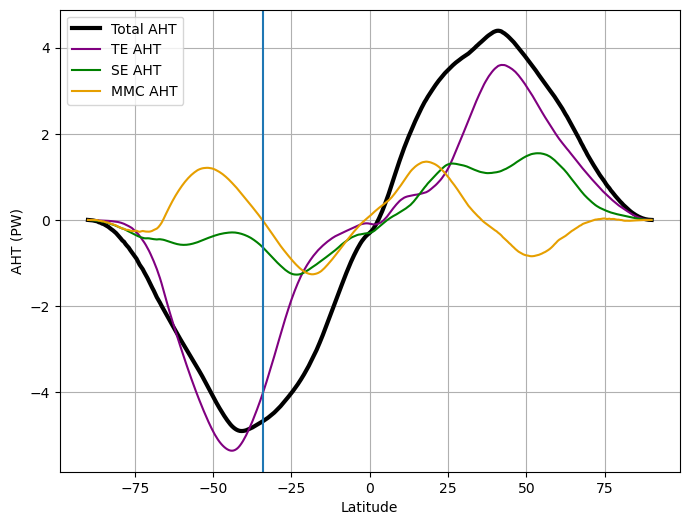

In [8]:
plt.figure(figsize=(8,6))

aht_clima = final_ds.mean(['time'])

plt.plot(lats, aht_clima.total_aht / 1e15, color='k', lw=3, label='Total AHT')
plt.plot(lats, aht_clima.te_aht / 1e15, color='purple', label='TE AHT')
plt.plot(lats, aht_clima.se_aht / 1e15, color='g', label='SE AHT')
plt.plot(lats, aht_clima.mmc_aht / 1e15, color='#E69F00', label='MMC AHT')

plt.axvline(-34)

plt.grid()
plt.legend(loc=0)

plt.xlabel('Latitude')
plt.ylabel('AHT (PW)')

#plt.savefig('../figures/general_exam_plots/aht_clima_tot_only')
plt.show()

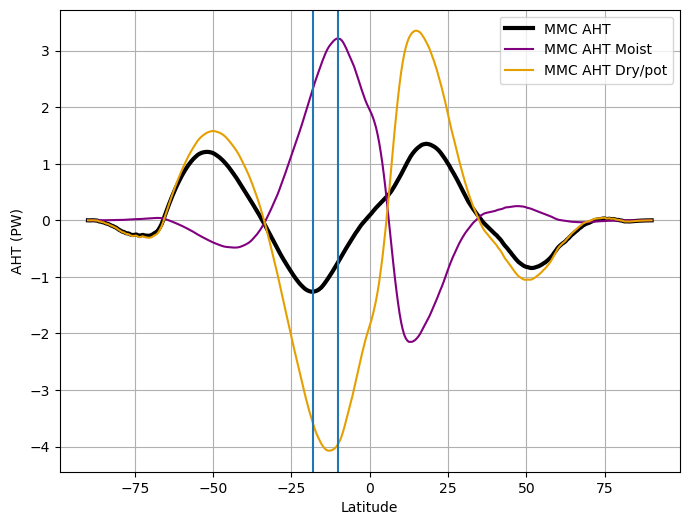

In [374]:
plt.figure(figsize=(8,6))

aht_clima = final_ds.mean(['time'])

plt.plot(lats, aht_clima.mmc_aht / 1e15, color='k', lw=3, label='MMC AHT')
plt.plot(lats, aht_clima.mmc_aht_moist / 1e15, color='purple', label='MMC AHT Moist')
plt.plot(lats, aht_clima.mmc_aht_dry_pot / 1e15, color='#E69F00', label='MMC AHT Dry/pot')

plt.axvline(-10)
plt.axvline(-18)

plt.grid()
plt.legend(loc=0)

plt.xlabel('Latitude')
plt.ylabel('AHT (PW)')

#plt.savefig('../figures/general_exam_plots/aht_clima_tot_only')
plt.show()

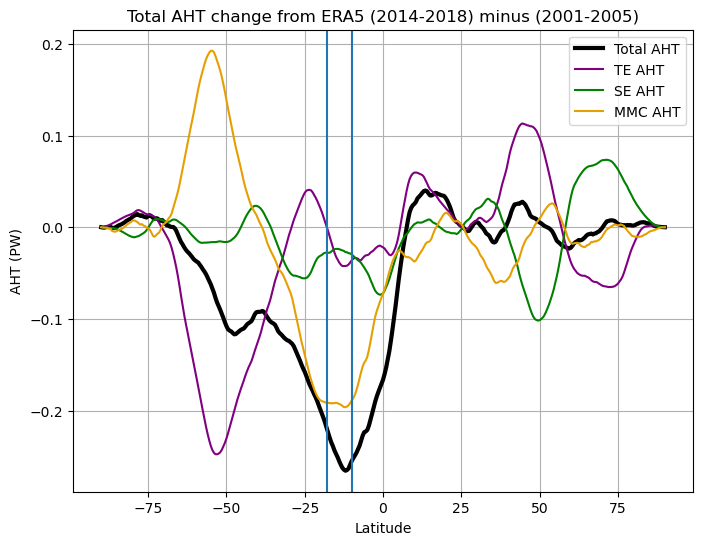

In [375]:
plt.figure(figsize=(8,6))

aht_change = final_ds.sel(time=slice('2009-01-01', '2018-12-31')).mean(['time']) - final_ds.sel(time=slice('1980-01-01', '1989-12-31')).mean(['time'])
#For ceres only timeframe
#aht_change = final_ds.sel(time=slice('2014-01-01', '2018-12-31')).mean(['time']) - final_ds.sel(time=slice('2001-01-01', '2005-12-31')).mean(['time'])


plt.plot(lats, aht_change.total_aht / 1e15, color='k', lw=3, label='Total AHT')
plt.plot(lats, aht_change.te_aht / 1e15, color='purple', label='TE AHT')
plt.plot(lats, aht_change.se_aht / 1e15, color='g', label='SE AHT')
plt.plot(lats, aht_change.mmc_aht / 1e15, color='#E69F00', label='MMC AHT')


#plt.plot(lats, aht_change.mmc_aht / 1e15, color='k', lw=3, label='Total')
#plt.plot(lats, aht_change.total_aht_dry / 1e15, color='r', lw=3, label='Dry AHT')
#plt.plot(lats, aht_change.mmc_aht_moist / 1e15, color='b', label='Moist AHT')
#plt.plot(lats, aht_change.total_aht_pot / 1e15, color='g', label='Pot AHT')
#plt.plot(lats, aht_change.mmc_aht_dry_pot / 1e15, color='g', label='Dry + Pot AHT')

plt.axvline(-10)
plt.axvline(-18)
plt.grid()
plt.legend(loc=0)

plt.xlabel('Latitude')
plt.ylabel('AHT (PW)')
plt.title('Total AHT change from ERA5 (2014-2018) minus (2001-2005)')
#plt.savefig('../figures/5_24_22_meeting/aht_changes_era5_ceres_era')
plt.show()

### Let's see trends by month in various places

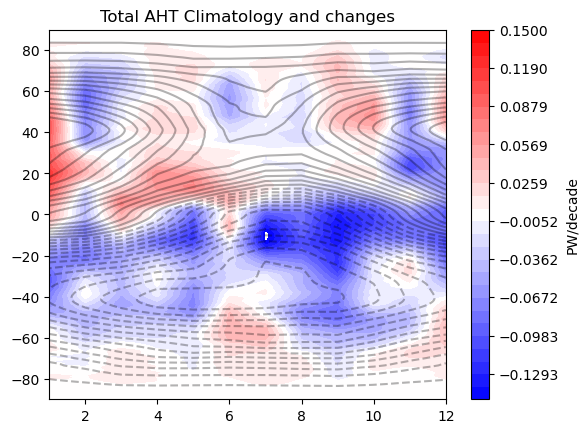

In [390]:


month_grouped = final_ds.groupby('time.month')

monthly_trends = np.zeros((12, len(lats)))

for i in range(12):
    
    data_new_time_dim = month_grouped[i+1].assign_coords({"time": range(39)})
    this_trend = data_new_time_dim.polyfit(dim='time', deg=1)
    monthly_trends[i,:] = this_trend.total_aht_polyfit_coefficients.sel(degree=1)

plt.contour(range(1,13), lats, month_grouped.mean(['time']).total_aht.T/1e15,
            levels=np.linspace(-6, 6, 30), colors='k', alpha=0.3)
plt.contourf(range(1, 13), lats, 10*monthly_trends.T/1e15, levels=np.linspace(-.15, .15, 30), cmap='bwr')

plt.colorbar(label='PW/decade')

plt.title('Total AHT Climatology and changes')

#plt.savefig('../figures/aht_changes/total_aht_clima_and_changes')
plt.show()

In [326]:
sec_per_year = 60 * 60 * 24 * 365

multiplier = 1
offset = 0
test = np.polyfit(range(39),
                              month_grouped[8].total_aht.sel(latitude=-30).values, 1)
                  
print(test/1e13)

[-4.49332415e-01 -5.12679748e+02]


In [327]:
value1 = monthly_trends[7,era_fncts.get_lat_idx(-30)]/1e13
value2 = test[0]/1e13
print(value2 - value1)

0.0


In [247]:
1.22e13 / .0004

#3.8e9 seconds since 1900

3.05e+16

In [246]:
.0005 * 60 * 60 * 24 * 365

15767.999999999998

### Hadley cell stuff

In [11]:
hadley_strength = pd.read_csv('../hadley_cell_strength_values.csv')

In [338]:
hadley_strength

,year,psi^min,psi^min(800 hPa),psi^min(775 hPa),psi^min(750 hPa),psi^min(700 hPa),psi^min(650 hPa),psi^min(600 hPa),psi^min(550 hPa),psi^min(500 hPa),psi^min(450 hPa),psi^min(400 hPa),<psi^min>_p,"psi(phi^min, p^min)",psi_SHC
0,1979,-1.15015,-1.10624,-1.13564,-1.15015,-1.13689,-1.07961,-1.00631,-0.93804,-0.87880,-0.83063,-0.79794,-0.88667,-1.10157,-0.44486
1,1980,-1.13232,-1.09872,-1.12426,-1.13232,-1.10778,-1.05201,-0.98822,-0.93426,-0.88807,-0.84635,-0.80544,-0.88169,-1.10778,-0.46017
2,1981,-1.10726,-1.08102,-1.10161,-1.10726,-1.08871,-1.04580,-0.99456,-0.94029,-0.88502,-0.84102,-0.81037,-0.88029,-1.08599,-0.44198
3,1982,-1.13745,-1.09575,-1.12503,-1.13745,-1.11731,-1.05953,-0.99279,-0.93480,-0.88227,-0.83890,-0.80258,-0.88572,-1.11640,-0.45738
4,1983,-1.13617,-1.11013,-1.12988,-1.13617,-1.12070,-1.07820,-1.02507,-0.97439,-0.92675,-0.88561,-0.84684,-0.90973,-1.10165,-0.42741
5,1984,-1.01495,-0.98023,-1.00192,-1.01495,-1.01154,-0.97777,-0.93187,-0.88861,-0.84768,-0.81138,-0.77837,-0.81917,-0.99146,-0.39560
6,1985,-1.03448,-0.98931,-1.01659,-1.03398,-1.03448,-0.99659,-0.94674,-0.89555,-0.84847,-0.80896,-0.77746,-0.82822,-1.02445,-0.41610
7,1986,-1.09537,-1.04888,-1.07983,-1.09537,-1.08756,-1.04488,-0.99169,-0.93803,-0.88948,-0.85002,-0.81974,-0.87421,-1.08756,-0.43728
8,1987,-1.17945,-1.11411,-1.15201,-1.17528,-1.17945,-1.13713,-1.07980,-1.01908,-0.96390,-0.92013,-0.88485,-0.93806,-1.17291,-0.45509
9,1988,-1.07558,-1.03249,-1.05700,-1.07037,-1.07558,-1.04904,-1.00672,-0.96279,-0.92260,-0.89009,-0.86119,-0.88456,-1.05828,-0.44043


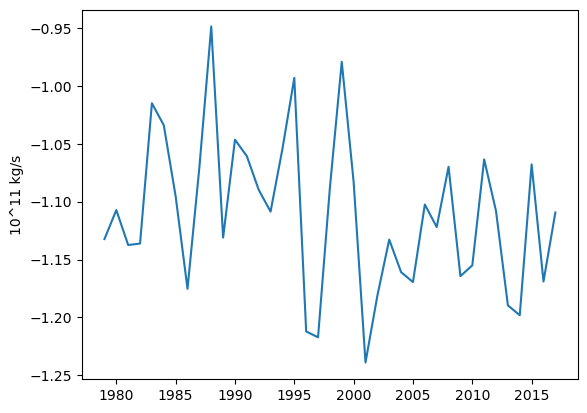

In [364]:
years=range(1979, 2018)

#plt.plot(years, hadley_strength['psi_SHC'][1:])
plt.plot(years, hadley_strength['psi^min(750 hPa)'][1:])

plt.ylabel('10^11 kg/s')
#plt.savefig('../figures/5_24_22_meeting/hadley_cell_sh_mass_transport_time_series')

plt.show()

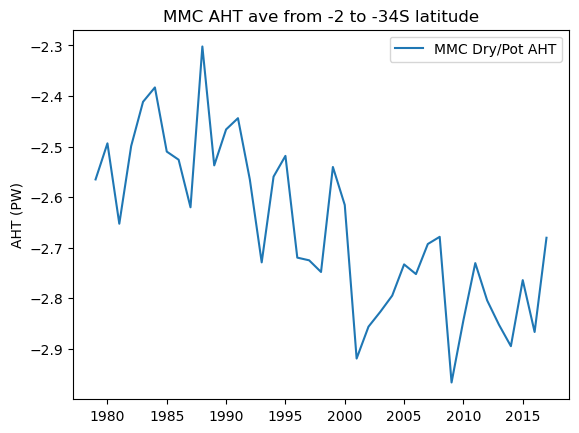

In [340]:
aht_variability = final_ds.groupby('time.year').mean(['time'])
aht_subsection = aht_variability.sel(latitude=slice(-2, -34)).mean(['latitude'])/1e15

#plt.plot(years, aht_subsection.mmc_aht,label='MMC AHT')
#plt.plot(years, aht_subsection.mmc_aht_moist,label='MMC Moist AHT')
plt.plot(years, aht_subsection.mmc_aht_dry_pot,label='MMC Dry/Pot AHT')

plt.ylabel('AHT (PW)')
plt.title('MMC AHT ave from -2 to -34S latitude')

plt.legend(loc=0)

#plt.savefig('../figures/5_24_22_meeting/mmc_aht_dry_pot_line_plot_-2_-34_lat_yearly_aves')

plt.show()

In [341]:
aht_subsection = aht_variability.sel(latitude=slice(-2, -34)).mean(['latitude'])/1e15

dry_moist_ratio = aht_subsection.mmc_aht_dry_pot / aht_subsection.mmc_aht_moist
dry_moist_ratio_norm = normalize_time_series(dry_moist_ratio)
dry_moist_ratio_no_trend = signal.detrend(dry_moist_ratio_norm, type='linear')

mmc_aht = aht_subsection.mmc_aht
mmc_aht_norm = normalize_time_series(mmc_aht)
mmc_aht_no_trend = signal.detrend(mmc_aht_norm, type='linear')

hadley_strength_time_series = hadley_strength['psi_SHC'][1:]
hadley_strength_norm = normalize_time_series(hadley_strength_time_series)
hadley_strength_no_trend = signal.detrend(hadley_strength_norm, type='linear')

combo_time_series = (dry_moist_ratio.values * hadley_strength_time_series.values)
multiplier = np.mean(mmc_aht.values) / np.mean(combo_time_series)
combo_time_series = combo_time_series * multiplier
combo_time_series_norm = normalize_time_series(combo_time_series)
combo_time_series_no_trend = signal.detrend(combo_time_series_norm, type='linear')


#aht_strength_corr = np.corrcoef(mmc_aht_norm, hadley_strength_norm)
#aht_dry_moist_corr = np.corrcoef(mmc_aht_norm, dry_moist_ratio_norm)
#strength_dry_moist_corr = np.corrcoef(hadley_strength_norm, dry_moist_ratio_norm)
#aht_combo_corr = np.corrcoef(mmc_aht_norm, combo_time_series)

aht_strength_corr = np.corrcoef(mmc_aht_no_trend, hadley_strength_no_trend)
aht_dry_moist_corr = np.corrcoef(mmc_aht_no_trend, dry_moist_ratio_no_trend)
strength_dry_moist_corr = np.corrcoef(hadley_strength_no_trend, dry_moist_ratio_no_trend)
aht_combo_corr = np.corrcoef(mmc_aht_no_trend, combo_time_series_no_trend)

print(aht_strength_corr[0,1])
print(aht_dry_moist_corr[0,1])
print(strength_dry_moist_corr[0,1])
print(aht_combo_corr[0,1])

0.22451113401629172
0.8630216885728915
-0.2304652942151288
0.622818255380231


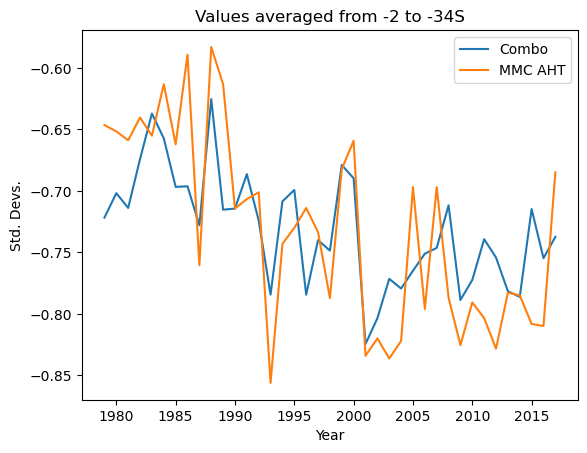

In [342]:
#plt.plot(years, dry_moist_ratio_no_trend, label='Dry moist')
#plt.plot(years, hadley_strength_no_trend, label='Hadley strength')
plt.plot(years, combo_time_series, label='Combo')
plt.plot(years, mmc_aht, label='MMC AHT')

plt.title('Values averaged from -2 to -34S')

plt.xlabel('Year')
plt.ylabel('Std. Devs.')

plt.legend(loc=0)

#plt.savefig('../figures/5_24_22_meeting/mmc_aht_combo_time_series_normalized_no_trend')
plt.show()


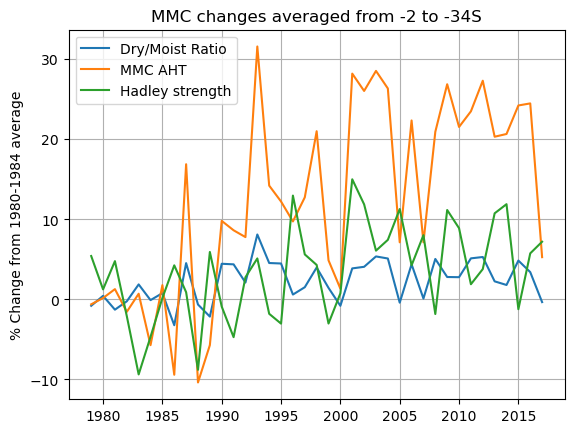

In [343]:

moist_dry_ratio_change = 100 * ((dry_moist_ratio / (np.mean(dry_moist_ratio[0:5]))) - 1)
plt.plot(years, moist_dry_ratio_change, label='Dry/Moist Ratio')

mmc_aht_change = 100 * ((mmc_aht / np.mean(mmc_aht[0:5])) -1)
plt.plot(years, mmc_aht_change, label='MMC AHT')

hadley_strength_change = 100 * ((hadley_strength_time_series / np.mean(hadley_strength_time_series[0:5])) -1)
plt.plot(years, hadley_strength_change, label='Hadley strength')

#plt.plot(years, 100 * ((combo_time_series/ combo_time_series[0]) - 1),
         #label='Both')
plt.ylabel('% Change from 1980-1984 average')
plt.title('MMC changes averaged from -2 to -34S')

plt.legend(loc=0)

plt.grid()

#plt.savefig('../figures/5_24_22_meeting/mmc_ratios_-2_-34S_no_combo')

plt.show()

In [344]:
lin_regress_aht = sc.linregress(years, mmc_aht)
lin_regress_dry_moist = sc.linregress(years, dry_moist_ratio * multiplier)
lin_regress_had_strength = sc.linregress(years, hadley_strength_time_series * multiplier)
lin_regress_combo = sc.linregress(years, combo_time_series)

In [345]:
print('AHT slope: ' + str(lin_regress_aht.slope))
print('Ratio slope: ' + str(lin_regress_dry_moist.slope))
print('Strength slope: ' + str(lin_regress_had_strength.slope))
print('Combo slope: ' + str(lin_regress_combo.slope))

AHT slope: -0.0046104503550499065
Ratio slope: 0.001377847177898674
Strength slope: 0.0012422981737306878
Combo slope: -0.0023223118203358427


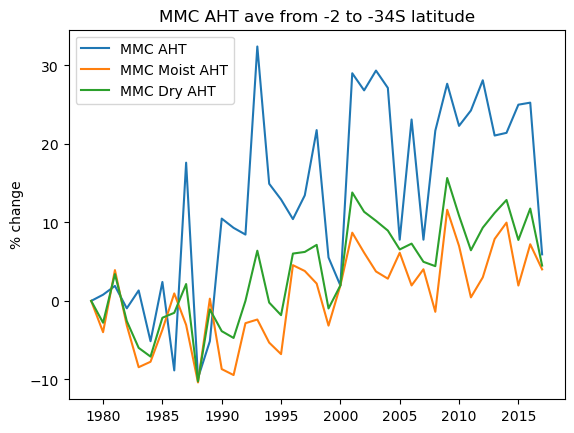

In [346]:
this_aht = aht_variability.mmc_aht.sel(latitude=slice(-2, -34)).mean(['latitude'])/1e15
this_aht_moist = aht_variability.mmc_aht_moist.sel(latitude=slice(-2, -34)).mean(['latitude'])/1e15
this_aht_dry_pot = aht_variability.mmc_aht_dry_pot.sel(latitude=slice(-2, -34)).mean(['latitude'])/1e15
plt.plot(years, 100 * ((this_aht/this_aht[0]) - 1),
        label='MMC AHT')
plt.plot(years, 100 * ((this_aht_moist/this_aht_moist[0]) - 1),
        label='MMC Moist AHT')
plt.plot(years, 100 * ((this_aht_dry_pot/this_aht_dry_pot[0]) - 1),
        label='MMC Dry AHT')

plt.ylabel('% change')
plt.title('MMC AHT ave from -2 to -34S latitude')

plt.legend(loc=0)

#plt.savefig('../figures/5_24_22_meeting/mmc_aht_line_plot_-2_-34S_lat__percent_change')

plt.show()

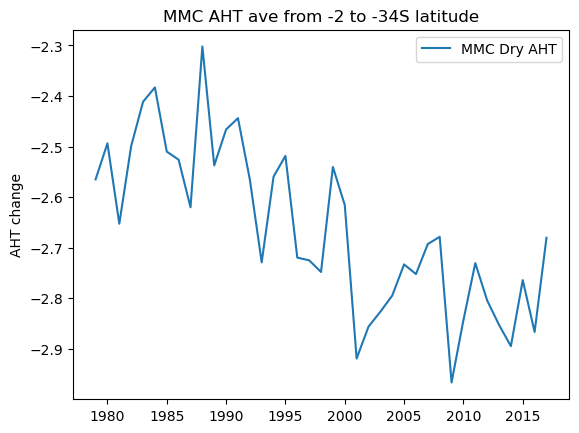

In [347]:
this_aht = aht_variability.mmc_aht.sel(latitude=slice(-2, -34)).mean(['latitude'])/1e15
this_aht_moist = aht_variability.mmc_aht_moist.sel(latitude=slice(-2, -34)).mean(['latitude'])/1e15
this_aht_dry_pot = aht_variability.mmc_aht_dry_pot.sel(latitude=slice(-2, -34)).mean(['latitude'])/1e15
#plt.plot(years, this_aht, label='MMC AHT')
#plt.plot(years,this_aht_moist, label='MMC Moist AHT')
plt.plot(years, this_aht_dry_pot, label='MMC Dry AHT')

plt.ylabel('AHT change')
plt.title('MMC AHT ave from -2 to -34S latitude')

plt.legend(loc=0)

#plt.savefig('../figures/5_24_22_meeting/te_aht_line_plot_-35_-65_lat__percent_change')

plt.show()

### Look at data on vertical stability and meridional wind

In [348]:
clima_files = sorted(glob('../era5_raw_data/monthly_data/*.nc'))
clima_data = xr.open_mfdataset(clima_files)

clima_data['mse'] = clima_data.t * cp + clima_data.q * L + clima_data.z

In [349]:
which_lat1 = -10
which_lat2 = -15

clima_data_sel = clima_data.sel(latitude=slice(which_lat1, which_lat2)).groupby('time.year').mean(['time']).load()

In [350]:
zon_norms = np.load('../Calculate_AHT/zonal_norms.npy')

clima_data_sel = clima_data_sel.sel(year=slice('1980', '2018'))
zon_norms_slice = zon_norms[:,era_fncts.get_lat_idx(which_lat1):era_fncts.get_lat_idx(which_lat2-0.5),:]
    
vcomp_data = np.nansum(clima_data_sel.v * zon_norms_slice[None,:,:,:], axis=3)
mse_data = np.nansum(clima_data_sel.mse * zon_norms_slice[None,:,:,:], axis=3)

In [351]:
weights = np.load('../Calculate_AHT/aht_weights.npy')

weights[np.isnan(weights)] = 0

weight_zonal_ave = np.nanmean(weights, axis=2)

weight_zonal_ave_slice = weight_zonal_ave[:,era_fncts.get_lat_idx(which_lat1):era_fncts.get_lat_idx(which_lat2-0.5)]
weight_zonal_ave_slice_mean = np.nanmean(weight_zonal_ave_slice, axis=1)
                                          

In [352]:
hadley_test = np.mean(vcomp_data * mse_data, axis=0)
vcomp_mean = np.mean(vcomp_data, axis=0)
mse_mean = np.mean(mse_data, axis=0)
product_mean = vcomp_mean * mse_mean
product_full = (vcomp_data * mse_data)
product_vcomp_mean = (vcomp_mean * mse_data)
product_mse_mean = (vcomp_data * mse_mean)

In [353]:
weighted_mean = np.nanmean(product_mean * weight_zonal_ave_slice, axis=1)
weighted_full = np.nanmean(product_full * weight_zonal_ave_slice[None,:,:], axis=2)
weighted_vcomp_mean = np.nanmean(product_vcomp_mean * weight_zonal_ave_slice[None,:,:], axis=2)
weighted_mse_mean = np.nanmean(product_mse_mean * weight_zonal_ave_slice[None,:,:], axis=2)

hadley_mean = np.sum(weighted_mean) / np.sum(weight_zonal_ave_slice_mean)
hadley_full = np.sum(weighted_full, axis=1) / np.sum(weight_zonal_ave_slice_mean)
hadley_vcomp_mean = np.sum(weighted_vcomp_mean, axis=1) / np.sum(weight_zonal_ave_slice_mean)
hadley_mse_mean = np.sum(weighted_mse_mean, axis=1) / np.sum(weight_zonal_ave_slice_mean)


0.15154583399388183
0.4488034282426789
0.12474453632200551


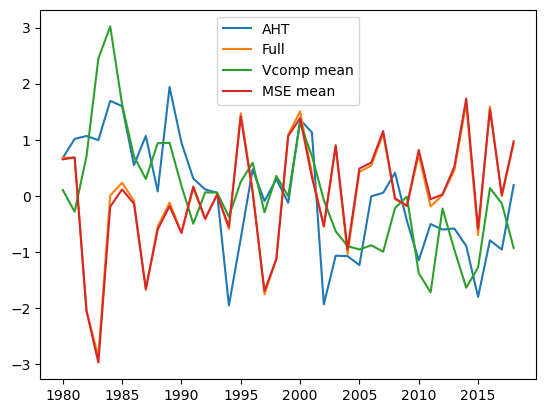

In [354]:
years = range(1980, 2019)

hadley_aht = aht_variability.mmc_aht.sel(latitude=slice(which_lat1, which_lat2)).mean(['latitude'])

plt.plot(years, normalize_time_series(hadley_aht), label='AHT')
plt.plot(years, normalize_time_series(hadley_full), label='Full')
plt.plot(years, normalize_time_series(hadley_vcomp_mean), label='Vcomp mean')
plt.plot(years, normalize_time_series(hadley_mse_mean), label='MSE mean')

#correlation = np.corrcoef(normalize_time_series(hadley_aht), normalize_time_series(hadley_full))[1,0]
correlation_full = np.corrcoef(signal.detrend(hadley_aht), signal.detrend(hadley_full))[1,0]
correlation_vcomp_mean = np.corrcoef(signal.detrend(hadley_aht), signal.detrend(hadley_vcomp_mean))[1,0]
correlation_mse_mean = np.corrcoef(signal.detrend(hadley_aht), signal.detrend(hadley_mse_mean))[1,0]

print(correlation_full)
print(correlation_vcomp_mean)
print(correlation_mse_mean)

plt.legend(loc=0)

plt.show()

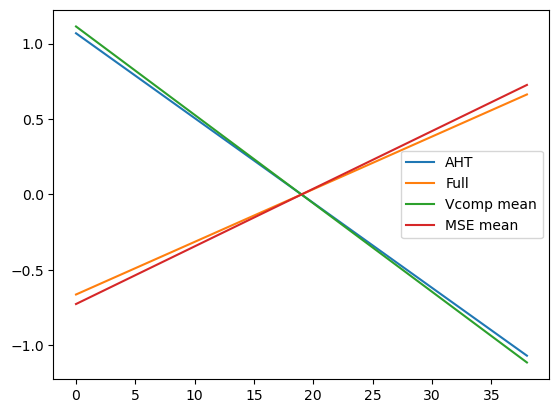

In [355]:
plt.plot(normalize_time_series(hadley_aht) - signal.detrend(normalize_time_series(hadley_aht), type='linear'), label='AHT')
plt.plot(normalize_time_series(hadley_full) - signal.detrend(normalize_time_series(hadley_full), type='linear'), label='Full')
plt.plot(normalize_time_series(hadley_vcomp_mean) - signal.detrend(normalize_time_series(hadley_vcomp_mean), type='linear'), label='Vcomp mean')
plt.plot(normalize_time_series(hadley_mse_mean) - signal.detrend(normalize_time_series(hadley_mse_mean), type='linear'), label='MSE mean')

plt.legend(loc=0)
plt.show()

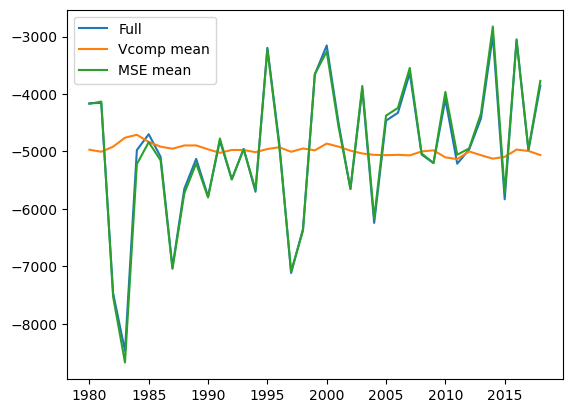

In [356]:
plt.plot(years, hadley_full, label='Full')
plt.plot(years, hadley_vcomp_mean, label='Vcomp mean')
plt.plot(years, hadley_mse_mean,label='MSE mean')

plt.legend(loc=0)
plt.show()

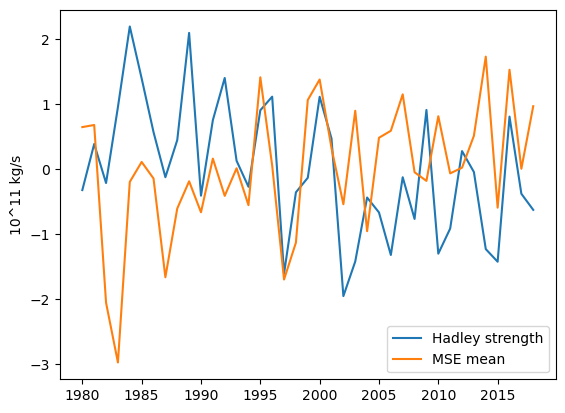

In [358]:
years=range(1980, 2019)

plt.plot(years, normalize_time_series(hadley_strength['psi_SHC'][1:]), label='Hadley strength')

plt.plot(years, normalize_time_series(hadley_mse_mean), label='MSE mean')

plt.legend(loc=0)
plt.ylabel('10^11 kg/s')
#plt.savefig('../figures/5_24_22_meeting/hadley_cell_sh_mass_transport_time_series')

plt.show()

### A new look at things

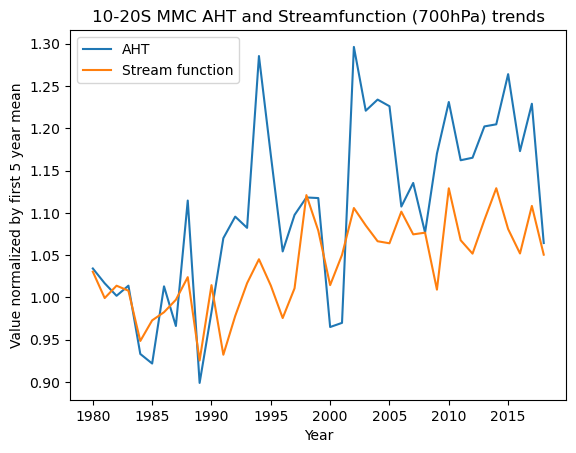

In [383]:
hadley_aht = final_ds.mmc_aht.sel(latitude=slice(-10, -20)).groupby('time.year').mean(['time', 'latitude'])
hadley_strm = strm_ds.strm_fnct.sel(latitude=slice(-10, -20), level=700).groupby('time.year').mean(['time', 'latitude'])


plt.plot(range(1980, 2019), hadley_aht / np.mean(hadley_aht[0:5]), label='AHT')
plt.plot(range(1980, 2019), hadley_strm / np.mean(hadley_strm[0:5]), label='Stream function')

plt.legend(loc=0)

plt.ylabel('Value normalized by first 5 year mean')
plt.xlabel('Year')

#plt.title('18S MMC AHT trends')
plt.title('10-20S MMC AHT and Streamfunction (700hPa) trends')

#plt.savefig('../figures/aht_changes/mmc_aht__strm_fnct_700hPa_10_to_20S_norm_by_1st_5_year_mean')

plt.show()